In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
#device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cpu


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [3]:
label = "Heat_tanh"

x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

DBC_pts = (Y == 0).reshape(-1,)


NBC_pts_x0 = (X == 0).reshape(-1,)
NBC_pts_x1 = (X == 1).reshape(-1,)

NBC_pts_y0 = (Y == 0).reshape(-1,)
NBC_pts_y1 = (Y == 1).reshape(-1,)

xyt_initial = xyt[initial_pts,:]
xyt_DBC = xyt[DBC_pts,:]

xyt_NBC_x0 = xyt[NBC_pts_x0,:]
xyt_NBC_x1 = xyt[NBC_pts_x1,:]

#xyt_NBC_y0 = xyt[NBC_pts_y0,:]
xyt_NBC_y1 = xyt[NBC_pts_y1,:]

u_initial = 300*np.ones((np.shape(xyt_initial)[0],1))
u_DBC = 1000*np.ones((np.shape(xyt_DBC)[0],1))

xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xyt_NBC_x = np.vstack((xyt_NBC_x0,xyt_NBC_x1))
#xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
xyt_NBC_y = np.vstack((xyt_NBC_y1))

u_I_DBC = np.vstack((u_initial,u_DBC))

xyt_test_tensor = torch.from_numpy(xyt).float().to(device)

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xyt_I_DBC.shape[0], N_D, replace=False) 
    xyt_D = xyt_I_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_I_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xyt_NBC_x.shape[0], N_D, replace=False) 
    xyt_Nx = xyt_NBC_x[idx,:] #choose indices from  set 'idx' (x,t)

    idx = np.random.choice(xyt_NBC_y.shape[0], N_D, replace=False) 
    xyt_Ny = xyt_NBC_y[idx,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xyt_coll = lb_xyt + (ub_xyt - lb_xyt)*samples
    xyt_coll = np.vstack((xyt_coll, xyt_D,xyt_Nx,xyt_Ny)) # append training points to collocation points 

    return xyt_coll, xyt_D, u_D, xyt_Nx,xyt_Ny

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
#         self.beta = Parameter(torch.ones((50,len(layers)-2)))
#         self.beta.requiresGrad = True
        
        self.alpha = Parameter(torch.zeros(5,len(layers)-2))
        self.omega = Parameter(torch.ones(5,len(layers)-2))
        
    
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            #print(z.shape)
            #z2 = torch.zeros(z1.shape).to(device)
            for j in range(5):
                #print(j)
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
                
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        #u_pred = self.test(xyt_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        #self.beta_val.append(self.alpha.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xyt_test_tensor):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [ ]:
max_reps = 1

train_loss_full = []
test_loss_full = []
#alpha_full = []
elapsed_time= np.zeros((max_reps,1))

#for reps in range(max_reps):
for reps in range(8,9):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 5000 #Total number of data points for 'y'
    N_N = 3500
    N_f = 10000#Total number of collocation points 
    
    xyt_coll_np_array, xyt_D_np_array, u_D_np_array,xyt_Nx_np_array,xyt_Ny_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xyt_coll = torch.from_numpy(xyt_coll_np_array).float().to(device)
    xyt_D = torch.from_numpy(xyt_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xyt_Nx = torch.from_numpy(xyt_Nx_np_array).float().to(device)
    xyt_Ny = torch.from_numpy(xyt_Ny_np_array).float().to(device)
        
    N_hat = torch.zeros(xyt_Nx.shape[0],1).to(device)    
    f_hat = torch.zeros(xyt_coll.shape[0],1).to(device)

    layers = np.array([3,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    #alpha_full.append(PINN.alpha_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time,  "label": label}
savemat(label+'.mat', mdic)

In [6]:
layers = np.array([3,50,50,50,50,50,50,50,50,50,1])
model_pinn = Sequentialmodel(layers)
model_pinn.load_state_dict(torch.load('Heat_rowdy_8.pt'))

<All keys matched successfully>

In [ ]:
del xyt_Nx
del xyt_Ny

In [ ]:
torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')

In [ ]:
del xyt_test_tensor


In [ ]:
#xyt_test_tensor = torch.from_numpy(xyt[1:50000,:]).float().to(device)

In [7]:
u_pred = model_pinn.test(xyt_test_tensor)
#u_pred2 = PINN.test(xyt_test_tensor[200000:,:])

#u_pred = np.vstack((u_pred1,u_pred2))

u_pred_3d = u_pred.reshape(100,100,100,order = 'F')

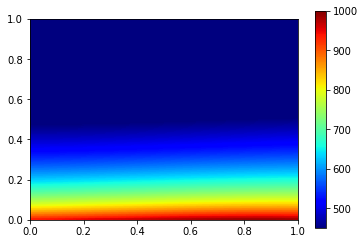

In [8]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.flipud(u_pred_3d[:,:,50]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
fig.colorbar(img3, orientation='vertical')

In [ ]:
import subprocess
import os

In [ ]:
def generate_video():
    for i in range(100):
        #plt.imshow(img[i], cmap=cm.Greys_r)
        img3 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
        
        plt.savefig("stan_heat_%02d.png" % i)

    #os.chdir()
    subprocess.call(['ffmpeg', '-framerate', '8', '-i', 'stan_heat_%02d.png', '-r', '10', '-pix_fmt', 'yuv420p','Stan_transient.mp4'])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [ ]:
generate_video()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


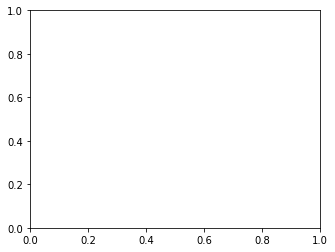

In [9]:
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
# img = [] # some array of images
frames = [] # for storing the generated images
# fig = plt.figure()
for i in range(100):
#     p1 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
#     fig.colorbar(p1, orientation='vertical',ax=ax)
    frames.append([plt.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)])
    print(i)

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
#ani.save('movie.mp4')
plt.show()

In [10]:
writergif = animation.PillowWriter(fps=10)
ani.save('rowdy_Thinplate_movie.gif',writer=writergif)

In [ ]:
writervideo = animation.FFMpegWriter(fps=60) 
ani.save('Stan_Thinplate_movie1.gif',writer=writervideo)

In [ ]:
np.max(u_pred_3d[:,:,50])

In [ ]:
plt.plot(u_pred_3d[50,99,:])

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)